# Wave Combinator Session Data Exploration

This template is designed to help you explore per-session data from the Wave Combinator game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

## Environment Setup and Import

In [1]:
import os
print(os.getcwd())
!pip install --quiet -r ../../requirements.txt

d:\Luke Swanson\D_Documents\_work\FieldDay\OpenGameData\opengamedata-samples\AQUALAB\templates


In [2]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tensorflow import keras

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [ ]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

### Load Data

#### Please change `OGD_SERVER` and `zip_name` if you want to get a file from a different location.
#### The cells below will error if `OGD_SERVER` and `zip_name` are invalid.

In [ ]:
OGD_SERVER = 'http://opengamedata.fielddaylab.wisc.edu/'
SERVER_DATA_PATH = 'data/AQUALAB/'

In [5]:
dataset_name = "AQUALAB_20230101_to_20230131"
zip_name = f"{dataset_name}_7565f43_player-features.zip"

Didn't find the file AQUALAB_20230101_to_20230131_7565f43_player-features.zip locally, downloading from OpenGameData...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   295  100   295    0     0   3771      0 --:--:-- --:--:-- --:--:--  3986


In [ ]:
# download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {OGD_SERVER}...")
    file_url = f"{OGD_SERVER}{SERVER_DATA_PATH}{zip_name}"
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")

In [ ]:
# Get file path and create data frame
tsv_name = f"{dataset_name}_7565f43_player-features.tsv"
tsv_path = Path("./") / dataset_name / tsv_name
# if not survey_path.is_file():
#     !unzip ./{zipname} -d {dataset_name}
raw_data = pd.read_csv(tsv_path, sep='\t')

In [8]:
#@markdown Do you want to filter player list?
Answer  = False#@param {type:"boolean"}
#@markdown Please change the file path if your player list is located differently.
PL_Path = "PlayerList.txt"#@param {type:"string"}
if Answer:
  player_list = pd.read_csv(JUPYTER_DIR / Path(PL_Path), sep='t', names=["Player"])
  raw_data = raw_data[raw_data.PlayerId.isin()]

# Cleaning and Transforms

## Data Overview

**Why are there so many na rows?** Sometimes, the na rows will be confusable for the users

In [9]:
cols_split = []
for col in raw_data.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job') or prefix.startswith('int') or prefix.startswith('obj') \
  or prefix.startswith('SA')  or prefix.startswith('Q'):
    cols_split.append(pieces[1])
  else:
    cols_split.append(col)
col_set = Counter(cols_split)
print(f"{len(raw_data.columns)} Columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

1359 Columns in 39 groups:
Counter({'JobActiveTime': 61,
         'JobArgumentationTime': 61,
         'JobCompletionTime': 61,
         'JobDiveSitesCount': 61,
         'JobDiveTime': 61,
         'JobExperimentationTime': 61,
         'JobGuideCount': 61,
         'JobHelpCount': 61,
         'JobHelpCount-ByTask': 61,
         'JobLocationChanges': 61,
         'JobLocationChanges-ByTask': 61,
         'JobModelingTime': 61,
         'JobTasksCompleted': 61,
         'SyncCompletionTime': 61,
         'JobsAttempted': 61,
         'JobsAttempted-job-name': 61,
         'JobsAttempted-num-starts': 61,
         'JobsAttempted-num-completes': 61,
         'JobsAttempted-percent-complete': 61,
         'JobsAttempted-avg-time-per-attempt': 61,
         'JobsAttempted-std-dev-per-attempt': 61,
         'JobsAttempted-job-difficulties': 61,
         'PlayerID': 1,
         'SessionCount': 1,
         'ActiveTime': 1,
         'JobsCompleted': 1,
         'SessionDiveSitesCount': 1,
     

In [18]:
raw_data.shape

(817, 1279)

In [19]:
raw_data.describe(include = 'all')

SessionID     PlayerID ActiveTime JobsCompleted  \
count          817          814        381           381   
unique         596          164        328           109   
top     1664887856  EternalLava    0:00:00            []   
freq             4           26         17           213   
mean           NaN          NaN        NaN           NaN   
std            NaN          NaN        NaN           NaN   
min            NaN          NaN        NaN           NaN   
25%            NaN          NaN        NaN           NaN   
50%            NaN          NaN        NaN           NaN   
75%            NaN          NaN        NaN           NaN   
max            NaN          NaN        NaN           NaN   

        SessionDiveSitesCount SessionDuration  SessionGuideCount  \
count              381.000000             381              381.0   
unique                    NaN             331                NaN   
top                       NaN         0:00:00                NaN   
freq                      NaN              16                NaN   
mean                 1.131234             NaN                0.0   
std                  1.421117             NaN                0.0   
min                  0.000000             NaN                0.0   
25%                  0.000000             NaN                0.0   
50%                  1.000000             NaN                0.0   
75%                  2.000000             NaN                0.0   
max                  7.000000             NaN                0.0   

        SessionHelpCount SessionID.1  SessionJobsCompleted  SwitchJobsCount  \
count         381.000000         381            381.000000       381.000000   
unique               NaN         372                   NaN              NaN   
top                  NaN  1664898425                   NaN              NaN   
freq                 NaN           2                   NaN              NaN   
mean            2.073491         NaN              0.902887         2.824147   
std             2.996464         NaN              1.356667         3.185170   
min             0.000000         NaN              0.000000         0.000000   
25%             0.000000         NaN              0.000000         1.000000   
50%             1.000000         NaN              0.000000         2.000000   
75%             3.000000         NaN              1.000000         5.000000   
max            17.000000         NaN              8.000000        20.000000   

       TopJobCompletionDestinations TopJobSwitchDestinations  \
count                           381                      381   
unique                          129                       83   
top                              {}                       {}   
freq                            253                      299   
mean                            NaN                      NaN   
std                             NaN                      NaN   
min                             NaN                      NaN   
25%                             NaN                      NaN   
50%                             NaN                      NaN   
75%                             NaN                      NaN   
max                             NaN                      NaN   

       TotalArgumentationTime TotalDiveTime TotalExperimentationTime  \
count                     381           381                      381   
unique                    159            70                      132   
top                   0:00:00       0:00:00                  0:00:00   
freq                      191           173                      216   
mean                      NaN           NaN                      NaN   
std                       NaN           NaN                      NaN   
min                       NaN           NaN                      NaN   
25%                       NaN           NaN                      NaN   
50%                       NaN           NaN                      NaN   
75%                       NaN    

In [20]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Columns: 1279 entries, SessionID to job59_JobsAttempted-job-difficulties
dtypes: float64(668), object(611)
memory usage: 8.0+ MB


In [21]:
raw_data[raw_data.PlayerID.isna()]

SessionID PlayerID ActiveTime JobsCompleted  SessionDiveSitesCount  \
0    Not Implemented      NaN  No events            []                    0.0   
145  Not Implemented      NaN        NaN           NaN                    NaN   
436  Not Implemented      NaN        NaN           NaN                    NaN   

       SessionDuration  SessionGuideCount  SessionHelpCount      SessionID.1  \
0    20 days, 11:24:25                0.0               0.0  Not Implemented   
145                NaN                NaN               NaN              NaN   
436                NaN                NaN               NaN              NaN   

     SessionJobsCompleted  SwitchJobsCount TopJobCompletionDestinations  \
0                     0.0              0.0                           {}   
145                   NaN              NaN                          NaN   
436                   NaN              NaN                          NaN   

    TopJobSwitchDestinations TotalArgumentationTime TotalDiveTime  \
0                         {}                0:00:00       0:00:00   
145                      NaN                    NaN           NaN   
436                      NaN                    NaN           NaN   

    TotalExperimentationTime job0_JobArgumentationTime  \
0                    0:00:00                   0:00:00   
145                      NaN                       NaN   
436                      NaN                       NaN   

    job1_JobArgumentationTime job2_JobArgumentationTime  \
0                     0:00:00                   0:00:00   
145                       NaN                       NaN   
436                       NaN                       NaN   

    job3_JobArgumentationTime job4_JobArgumentationTime  \
0                     0:00:00                   0:00:00   
145                       NaN                       NaN   
436                       NaN                       NaN   

    job5_JobArgumentationTime job6_JobArgumentationTime  \
0                     0:00:00                   0:00:00   
145                       NaN                       NaN   
436                       NaN                       NaN   

    job7_JobArgumentationTime job8_JobArgumentationTime  \
0                     0:00:00                   0:00:00   
145                       NaN                       NaN   
436                       NaN                       NaN   

    job9_JobArgumentationTime job10_JobArgumentationTime  \
0                     0:00:00                    0:00:00   
145                       NaN                        NaN   
436                       NaN                        NaN   

    job11_JobArgumentationTime job12_JobArgumentationTime  \
0                      0:00:00                    0:00:00   
145                        NaN                        NaN   
436                        NaN                        NaN   

    job13_JobArgumentationTime job14_JobArgumentationTime  \
0                      0:00:00                    0:00:00   
145                        NaN                        NaN   
436                        NaN                        NaN   

    job15_JobArgumentationTime job16_JobArgumentationTime  \
0                      0:00:00                    0:00:00   
145                        NaN                        NaN   
436                        NaN                        NaN   

    job17_JobArgumentationTime job18_JobArgumentationTime  \
0                      0:00:00                    0:00:00   
145                        NaN                        NaN   
436                        NaN                        NaN   

    job19_JobArgumentationTime job20_JobArgumentationTime  \
0                      0:00:00                    0:00:00   
145                        NaN                        NaN   
436                        NaN                        NaN   

    job21_JobArgumentationTime job22_JobArgumentationTime  \
0                      0:00:00                    0:00:00   
145               

In [22]:
raw_data[raw_data.isnull().any(axis = 1)].head(10)

SessionID     PlayerID ActiveTime JobsCompleted  \
0    Not Implemented          NaN  No events            []   
145  Not Implemented          NaN        NaN           NaN   
146       1664631374  EternalLava        NaN           NaN   
147       1664639337  EternalLava        NaN           NaN   
148       1664643298  EternalLava        NaN           NaN   
149       1664900610  EternalLava        NaN           NaN   
150       1664905982  EternalLava        NaN           NaN   
151       1664914712  EternalLava        NaN           NaN   
156       1664645348   AwakePenny        NaN           NaN   
157       1665453991   AwakePenny        NaN           NaN   

     SessionDiveSitesCount    SessionDuration  SessionGuideCount  \
0                      0.0  20 days, 11:24:25                0.0   
145                    NaN                NaN                NaN   
146                    NaN                NaN                NaN   
147                    NaN                NaN                NaN   
148                    NaN                NaN                NaN   
149                    NaN                NaN                NaN   
150                    NaN                NaN                NaN   
151                    NaN                NaN                NaN   
156                    NaN                NaN                NaN   
157                    NaN                NaN                NaN   

     SessionHelpCount      SessionID.1  SessionJobsCompleted  SwitchJobsCount  \
0                 0.0  Not Implemented                   0.0              0.0   
145               NaN              NaN                   NaN              NaN   
146               NaN              NaN                   NaN              NaN   
147               NaN              NaN                   NaN              NaN   
148               NaN              NaN                   NaN              NaN   
149               NaN              NaN                   NaN              NaN   
150               NaN              NaN                   NaN              NaN   
151               NaN              NaN                   NaN              NaN   
156               NaN              NaN                   NaN              NaN   
157               NaN              NaN                   NaN              NaN   

    TopJobCompletionDestinations TopJobSwitchDestinations  \
0                             {}                       {}   
145                          NaN                      NaN   
146                          NaN                      NaN   
147                          NaN                      NaN   
148                          NaN                      NaN   
149                          NaN                      NaN   
150                          NaN                      NaN   
151                          NaN                      NaN   
156                          NaN                      NaN   
157                          NaN                      NaN   

    TotalArgumentationTime TotalDiveTime TotalExperimentationTime  \
0                  0:00:00       0:00:00                  0:00:00   
145                    NaN           NaN                      NaN   
146                    NaN           NaN                      NaN   
147                    NaN           NaN                      NaN   
148                    NaN           NaN                      NaN   
149                    NaN           NaN                      NaN   
150                    NaN           NaN                      NaN   
151                    NaN           NaN                      NaN   
156                    NaN           NaN                      NaN   
157                    NaN           NaN                      NaN   

    job0_JobArgumentationTime job1_JobArgumentationTime  \
0                     0:00:00                   0:00:00   
145                       NaN                       NaN   
146                       NaN                       NaN   
147                

## Data Cleaning

In [23]:
df_session = raw_data.dropna()
df_session.describe(include="all")

SessionID        PlayerID ActiveTime JobsCompleted  \
count          380             380        380           380   
unique         371             164        327           109   
top     1664898425  CluelessHelmet    0:00:00            []   
freq             2              11         17           212   
mean           NaN             NaN        NaN           NaN   
std            NaN             NaN        NaN           NaN   
min            NaN             NaN        NaN           NaN   
25%            NaN             NaN        NaN           NaN   
50%            NaN             NaN        NaN           NaN   
75%            NaN             NaN        NaN           NaN   
max            NaN             NaN        NaN           NaN   

        SessionDiveSitesCount SessionDuration  SessionGuideCount  \
count              380.000000             380              380.0   
unique                    NaN             330                NaN   
top                       NaN         0:00:00                NaN   
freq                      NaN              16                NaN   
mean                 1.134211             NaN                0.0   
std                  1.421801             NaN                0.0   
min                  0.000000             NaN                0.0   
25%                  0.000000             NaN                0.0   
50%                  1.000000             NaN                0.0   
75%                  2.000000             NaN                0.0   
max                  7.000000             NaN                0.0   

        SessionHelpCount SessionID.1  SessionJobsCompleted  SwitchJobsCount  \
count         380.000000         380            380.000000       380.000000   
unique               NaN         371                   NaN              NaN   
top                  NaN  1664898425                   NaN              NaN   
freq                 NaN           2                   NaN              NaN   
mean            2.078947         NaN              0.905263         2.831579   
std             2.998518         NaN              1.357661         3.186060   
min             0.000000         NaN              0.000000         0.000000   
25%             0.000000         NaN              0.000000         1.000000   
50%             1.000000         NaN              0.000000         2.000000   
75%             3.000000         NaN              1.000000         5.000000   
max            17.000000         NaN              8.000000        20.000000   

       TopJobCompletionDestinations TopJobSwitchDestinations  \
count                           380                      380   
unique                          129                       83   
top                              {}                       {}   
freq                            252                      298   
mean                            NaN                      NaN   
std                             NaN                      NaN   
min                             NaN                      NaN   
25%                             NaN                      NaN   
50%                             NaN                      NaN   
75%                             NaN                      NaN   
max                             NaN                      NaN   

       TotalArgumentationTime TotalDiveTime TotalExperimentationTime  \
count                     380           380                      380   
unique                    159            70                      132   
top                   0:00:00       0:00:00                  0:00:00   
freq                      190           172                      215   
mean                      NaN           NaN                      NaN   
std                       NaN           NaN                      NaN   
min                       NaN           NaN                      NaN   
25%                       NaN           NaN                      NaN   
50%                       NaN           NaN                      NaN 

In [24]:
Constant_cols = df_session.columns[df_session.describe(include="all").loc['unique'] <=2]
perjob_cons_cols = dict()
agg_cons_cols = set()
for col in Constant_cols:
  if col[0:3] == "job":
    feature = col.split("_")[1]
    if feature in perjob_cons_cols:
      perjob_cons_cols[feature] += 1
    else:
      perjob_cons_cols[feature] = 1
    continue
  agg_cons_cols.add(col)
print("Zero perjob features are: ", [k for k, v in perjob_cons_cols.items() if v == 60 ])
print("Zero aggregate features are: ", agg_cons_cols)

Zero perjob features are:  ['JobModelingTime', 'SyncCompletionTime', 'JobsAttempted-job-name', 'JobsAttempted-job-difficulties']
Zero aggregate features are:  set()


In [25]:
df_session = df_session.convert_dtypes()
df_session.dtypes

SessionID                                   object
PlayerID                                    string
ActiveTime                                  string
JobsCompleted                               string
SessionDiveSitesCount                        Int64
                                             ...  
job59_JobsAttempted-num-completes            Int64
job59_JobsAttempted-percent-complete         Int64
job59_JobsAttempted-avg-time-per-attempt     Int64
job59_JobsAttempted-std-dev-per-attempt      Int64
job59_JobsAttempted-job-difficulties        string
Length: 1279, dtype: object

In [26]:
for col, dtype in zip(df_session, df_session.dtypes):
  if dtype == "string":
    try:
      df_session[col] = pd.to_timedelta(df_session[col])
    except:
      pass

In [27]:
df_session.dtypes

SessionID                                            object
PlayerID                                             string
ActiveTime                                  timedelta64[ns]
JobsCompleted                                        string
SessionDiveSitesCount                                 Int64
                                                 ...       
job59_JobsAttempted-num-completes                     Int64
job59_JobsAttempted-percent-complete                  Int64
job59_JobsAttempted-avg-time-per-attempt              Int64
job59_JobsAttempted-std-dev-per-attempt               Int64
job59_JobsAttempted-job-difficulties                 string
Length: 1279, dtype: object

In [28]:
df_session.describe(include='all')

SessionID        PlayerID                 ActiveTime JobsCompleted  \
count          380             380                        380           380   
unique         371             164                        NaN           109   
top     1664898425  CluelessHelmet                        NaN            []   
freq             2              11                        NaN           212   
mean           NaN             NaN     0 days 00:13:45.400000           NaN   
std            NaN             NaN  0 days 00:13:35.321273420           NaN   
min            NaN             NaN            0 days 00:00:00           NaN   
25%            NaN             NaN     0 days 00:02:48.500000           NaN   
50%            NaN             NaN     0 days 00:10:57.500000           NaN   
75%            NaN             NaN     0 days 00:21:22.750000           NaN   
max            NaN             NaN            0 days 01:47:18           NaN   

        SessionDiveSitesCount            SessionDuration  SessionGuideCount  \
count              380.000000                        380              380.0   
unique                    NaN                        NaN                NaN   
top                       NaN                        NaN                NaN   
freq                      NaN                        NaN                NaN   
mean                 1.134211  0 days 00:50:39.307894736                0.0   
std                  1.421801  0 days 03:13:06.634369983                0.0   
min                  0.000000            0 days 00:00:00                0.0   
25%                  0.000000            0 days 00:06:34                0.0   
50%                  1.000000            0 days 00:23:29                0.0   
75%                  2.000000     0 days 00:34:14.250000                0.0   
max                  7.000000            1 days 02:22:04                0.0   

        SessionHelpCount SessionID.1  SessionJobsCompleted  SwitchJobsCount  \
count         380.000000         380            380.000000       380.000000   
unique               NaN         371                   NaN              NaN   
top                  NaN  1664898425                   NaN              NaN   
freq                 NaN           2                   NaN              NaN   
mean            2.078947         NaN              0.905263         2.831579   
std             2.998518         NaN              1.357661         3.186060   
min             0.000000         NaN              0.000000         0.000000   
25%             0.000000         NaN              0.000000         1.000000   
50%             1.000000         NaN              0.000000         2.000000   
75%             3.000000         NaN              1.000000         5.000000   
max            17.000000         NaN              8.000000        20.000000   

       TopJobCompletionDestinations TopJobSwitchDestinations  \
count                           380                      380   
unique                          129                       83   
top                              {}                       {}   
freq                            252                      298   
mean                            NaN                      NaN   
std                             NaN                      NaN   
min                             NaN                      NaN   
25%                             NaN                      NaN   
50%                             NaN                      NaN   
75%                             NaN                      NaN   
max                             NaN                      NaN   

           TotalArgumentationTime              TotalDiveTime  \
count                         380                        380   
unique                        NaN                        NaN   
top                           NaN                        NaN   
freq                          NaN                        NaN   
mean       0 days 00:02:34.400000  0 days 00:00:16.513157894   
std     0

In [29]:
df_session.dtypes.unique()

array([dtype('O'), string[python], dtype('<m8[ns]'), Int64Dtype(),
       Float64Dtype()], dtype=object)

In [30]:
df_session.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


# Visualizations

## ArgumentationTime feature visualization

### removing outliers

In [31]:
#@markdown Type a perjob feature name here
Interested_perjobfeature = 'ArgumentationTime'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}


In [32]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [33]:
target_columns = df_session.columns[df_session.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_session[id_columns.append(target_columns)].copy()
df_Interested.head()

SessionID     PlayerID TotalArgumentationTime job0_JobArgumentationTime  \
0  1664631374  EternalLava        0 days 00:00:56                    0 days   
1  1664639337  EternalLava        0 days 00:00:00                    0 days   
2  1664643298  EternalLava        0 days 00:01:37                    0 days   
3  1664900610  EternalLava        0 days 00:04:11                    0 days   
4  1664905982  EternalLava        0 days 00:00:00                    0 days   

  job1_JobArgumentationTime job2_JobArgumentationTime  \
0                    0 days                    0 days   
1                    0 days                    0 days   
2                    0 days                    0 days   
3                    0 days                    0 days   
4                    0 days                    0 days   

  job3_JobArgumentationTime job4_JobArgumentationTime  \
0                    0 days                    0 days   
1                    0 days                    0 days   
2                    0 days                    0 days   
3                    0 days                    0 days   
4                    0 days                    0 days   

  job5_JobArgumentationTime job6_JobArgumentationTime  \
0                    0 days                    0 days   
1                    0 days                    0 days   
2                    0 days                    0 days   
3                    0 days                    0 days   
4                    0 days                    0 days   

  job7_JobArgumentationTime job8_JobArgumentationTime  \
0                    0 days                    0 days   
1                    0 days                    0 days   
2                    0 days                    0 days   
3                    0 days                    0 days   
4                    0 days                    0 days   

  job9_JobArgumentationTime job10_JobArgumentationTime  \
0                    0 days                     0 days   
1                    0 days                     0 days   
2                    0 days                     0 days   
3                    0 days                     0 days   
4                    0 days                     0 days   

  job11_JobArgumentationTime job12_JobArgumentationTime  \
0                     0 days                     0 days   
1                     0 days                     0 days   
2                     0 days                     0 days   
3                     0 days                     0 days   
4                     0 days                     0 days   

  job13_JobArgumentationTime job14_JobArgumentationTime  \
0                     0 days            0 days 00:00:00   
1                     0 days            0 days 00:00:00   
2                     0 days            0 days 00:00:00   
3                     0 days            0 days 00:04:11   
4                     0 days            0 days 00:00:00   

  job15_JobArgumentationTime job16_JobArgumentationTime  \
0                     0 days                     0 days   
1                     0 days                     0 days   
2                     0 days                     0 days   
3                     0 days                     0 days   
4                     0 days                     0 days   

  job17_JobArgumentationTime job18_JobArgumentationTime  \
0                     0 days                     0 days   
1                     0 days                     0 days   
2                     0 days                     0 days   
3                     0 days                     0 days   
4                     0 days                     0 days   

  job19_JobArgumentationTime job20_JobArgumentationTime  \
0                     0 days                     0 days   
1                     0 days                     0 days   
2                     0 days                     0 days   
3                     0 days                     0 days   
4                     0 days                     0 days   

  job21_JobArgumentationTime job2

Execute the following chunk only when the features are timedelta

In [34]:
for col in target_columns:
  df_Interested[col] = df_Interested[col].dt.total_seconds()


In [35]:
bigoutliers = np.where(df_Interested[target_columns].ge(4000))
bigoutliers

(array([ 30, 169]), array([ 0, 29]))

In [36]:
df_Interested[target_columns].iloc[bigoutliers]

TotalArgumentationTime  job28_JobArgumentationTime
30                   4275.0                         0.0
169                   267.0                     84259.0

In [37]:
for i, j in zip(bigoutliers[0], bigoutliers[1]):
  df_Interested[target_columns].iat[i, j] = 0

### heatmap

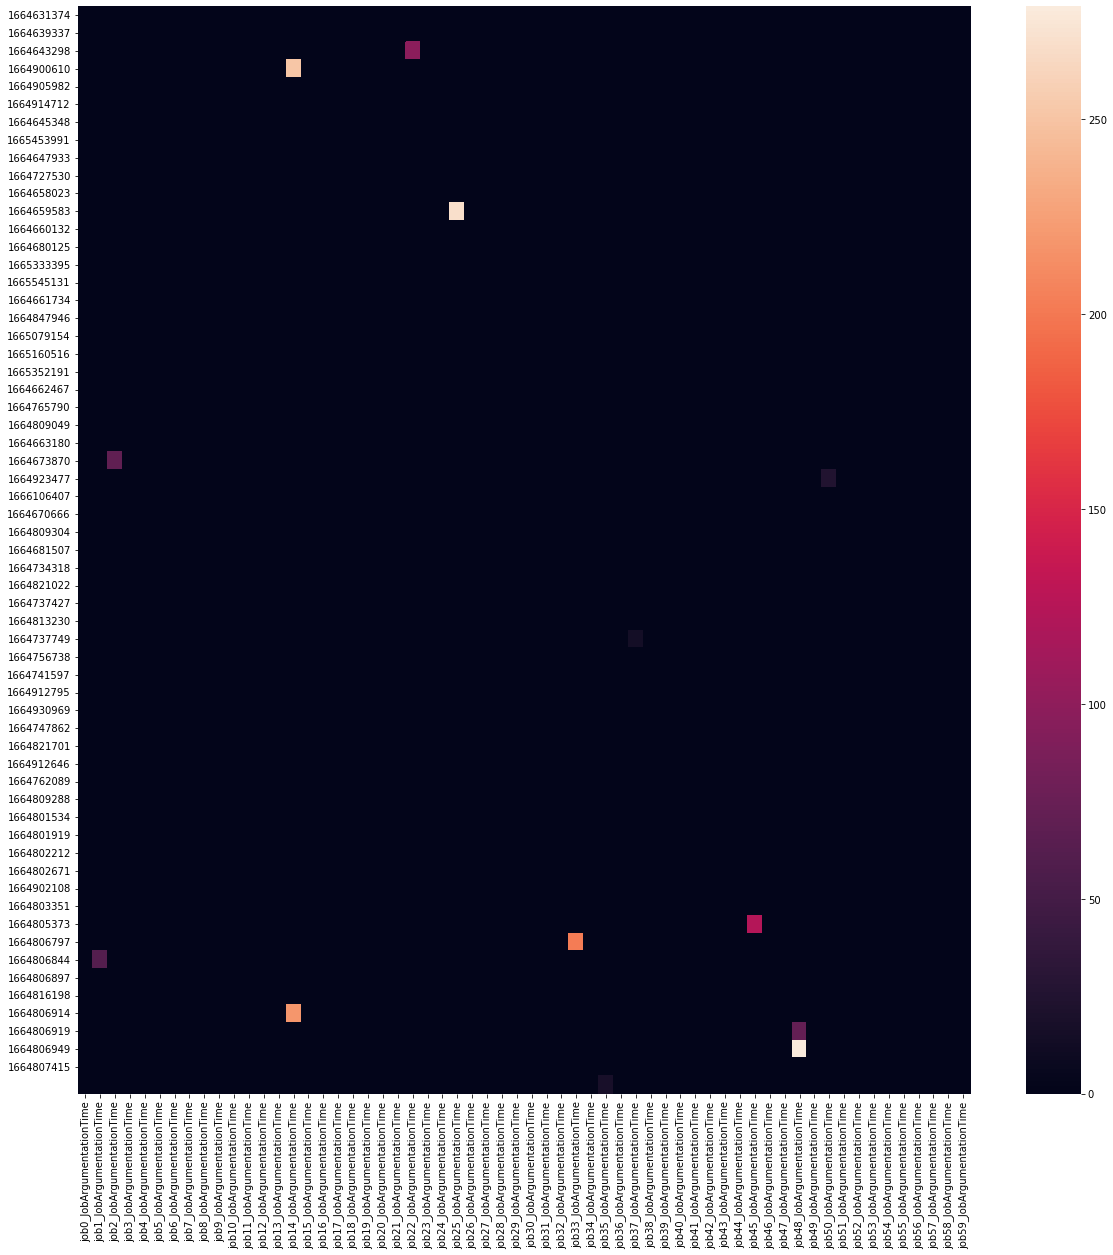

In [38]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
if Answer:
  sns.heatmap(df_Interested.loc[0:60, target_columns[1:]], yticklabels=df_Interested.SessionID[0:60], ax=ax)
else:
  sns.heatmap(df_Interested.loc[0:60, target_columns], yticklabels=df_Interested.SessionID[0:60], ax=ax)


## Some aggregate feature visualization

### Cleaning for visualizations

In [39]:
target_columns = df_session.columns[~df_session.columns.str.contains('job')]
df_Aggregate = df_session[target_columns].copy()

In [40]:
df_Aggregate.head()

index   SessionID     PlayerID      ActiveTime  \
0      1  1664631374  EternalLava 0 days 00:12:31   
1      2  1664639337  EternalLava 0 days 00:08:03   
2      3  1664643298  EternalLava 0 days 00:15:46   
3      4  1664900610  EternalLava 0 days 00:19:04   
4      5  1664905982  EternalLava 0 days 00:02:00   

                         JobsCompleted  SessionDiveSitesCount SessionDuration  \
0  ['displaced-reef', 'turtle-danger']                      2 0 days 00:16:45   
1                                   []                      2 0 days 00:08:58   
2                                   []                      0 0 days 00:24:41   
3                                   []                      1 0 days 00:24:15   
4                                   []                      0 0 days 00:10:39   

   SessionGuideCount  SessionHelpCount SessionID.1  SessionJobsCompleted  \
0                  0                 0  1664631374                     2   
1                  0                 1  1664639337                     0   
2                  0                 9  1664643298                     0   
3                  0                 4  1664900610                     0   
4                  0                 0  1664905982                     0   

   SwitchJobsCount                       TopJobCompletionDestinations  \
0                6  {"displaced-reef": {"turtle-danger": ["Eternal...   
1                1                                                 {}   
2                1                                                 {}   
3                2                                                 {}   
4                1                                                 {}   

                            TopJobSwitchDestinations TotalArgumentationTime  \
0  {"coral-fake-fix": {"displaced-reef": ["Eterna...        0 days 00:00:56   
1                                                 {}        0 days 00:00:00   
2                                                 {}        0 days 00:01:37   
3  {"coral-fake-fix": {"kelp-save-urchin-barren":...        0 days 00:04:11   
4                                                 {}        0 days 00:00:00   

    TotalDiveTime TotalExperimentationTime  UserAvgSessionDuration  \
0 0 days 00:00:22          0 days 00:00:56                142418.5   
1 0 days 00:00:21          0 days 00:00:00                142185.0   
2 0 days 00:00:00          0 days 00:01:48                142656.5   
3 0 days 00:00:08          0 days 00:00:50                142643.5   
4 0 days 00:00:00          0 days 00:00:00                142235.5   

   UserSessionCount  UserTotalSessionDuration  
0                 2                    284837  
1                 2                    284370  
2                 2                    285313  
3                 2                    285287  
4                 2                    284471

In [41]:
target_columns = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime', 'UserSessionCount', 'SessionJobsCompleted', 'SwitchJobsCount']
for col in ['ActiveTime', 'TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']:
  df_Aggregate[col] = df_Aggregate[col].dt.total_seconds()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bcca0390>,
      dtype=object)

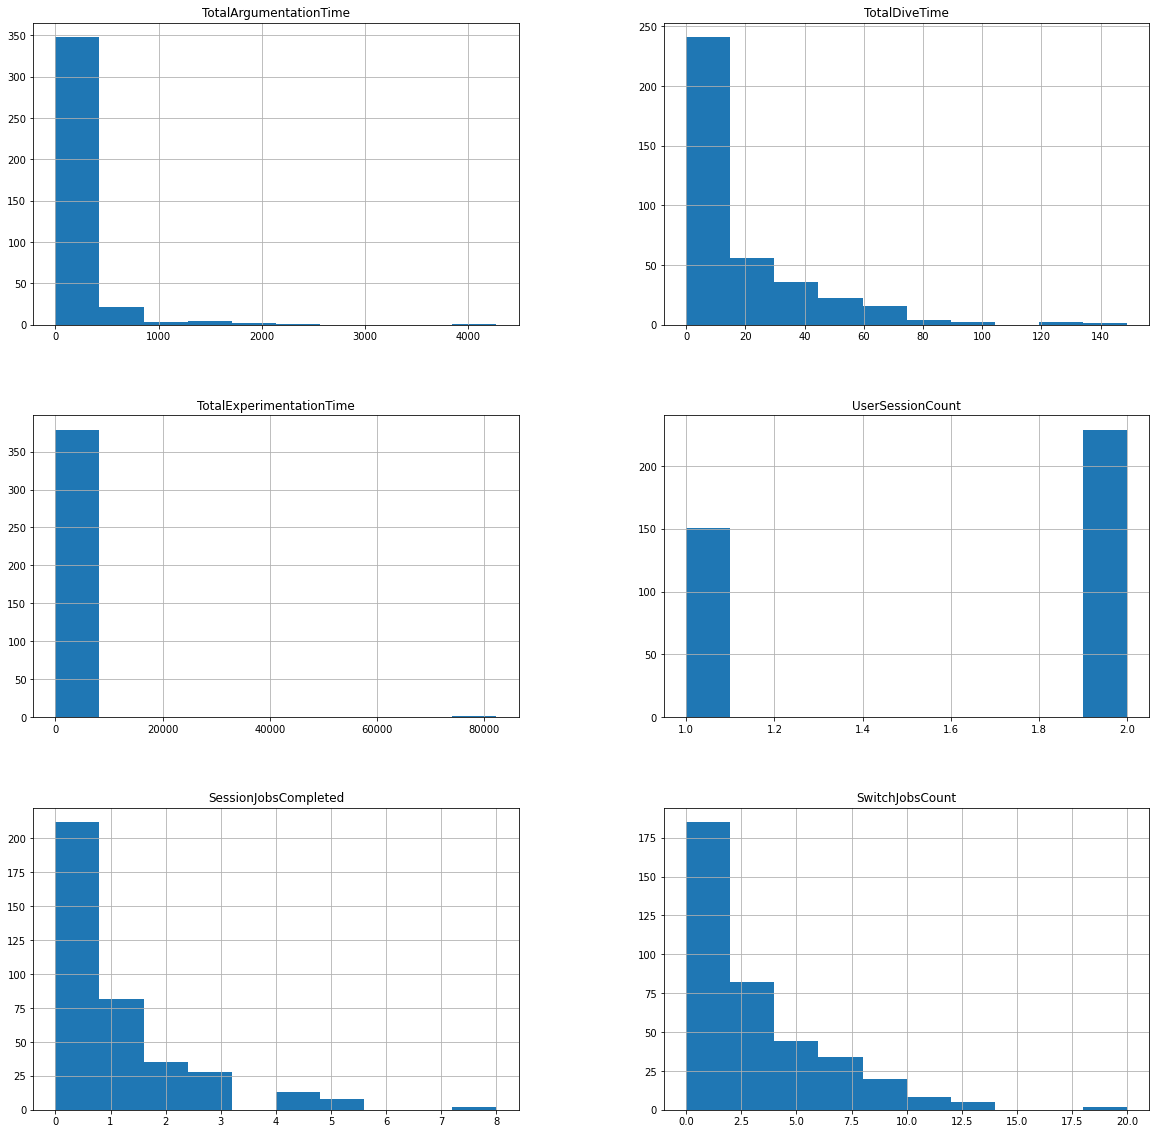

In [42]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

Here we find that there may be an outlier in TotalExperimentationTime feature. Let's remove it and impute with 0. For some other data, you can do your own cleaning and use other imputation method.

In [43]:
df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > 5000]

index   SessionID       PlayerID      ActiveTime  \
169    214  1664753795  UltimateShark 0 days 00:34:38   

                                         JobsCompleted  SessionDiveSitesCount  \
169  ['kelp-refuge-failure', 'kelp-refuge-failure-s...                      3   

    SessionDuration  SessionGuideCount  SessionHelpCount SessionID.1  \
169 0 days 23:44:13                  0                 7  1664753795   

     SessionJobsCompleted  SwitchJobsCount  \
169                     2                5   

                          TopJobCompletionDestinations  \
169  {"kelp-refuge-failure": {"kelp-refuge-failure-...   

    TopJobSwitchDestinations TotalArgumentationTime   TotalDiveTime  \
169                       {}        0 days 00:04:27 0 days 00:00:29   

    TotalExperimentationTime job0_JobArgumentationTime  \
169          0 days 22:50:40                    0 days   

    job1_JobArgumentationTime job2_JobArgumentationTime  \
169                    0 days                    0 days   

    job3_JobArgumentationTime job4_JobArgumentationTime  \
169                    0 days                    0 days   

    job5_JobArgumentationTime job6_JobArgumentationTime  \
169                    0 days                    0 days   

    job7_JobArgumentationTime job8_JobArgumentationTime  \
169                    0 days                    0 days   

    job9_JobArgumentationTime job10_JobArgumentationTime  \
169                    0 days                     0 days   

    job11_JobArgumentationTime job12_JobArgumentationTime  \
169                     0 days                     0 days   

    job13_JobArgumentationTime job14_JobArgumentationTime  \
169                     0 days                     0 days   

    job15_JobArgumentationTime job16_JobArgumentationTime  \
169                     0 days                     0 days   

    job17_JobArgumentationTime job18_JobArgumentationTime  \
169                     0 days                     0 days   

    job19_JobArgumentationTime job20_JobArgumentationTime  \
169                     0 days                     0 days   

    job21_JobArgumentationTime job22_JobArgumentationTime  \
169                     0 days                     0 days   

    job23_JobArgumentationTime job24_JobArgumentationTime  \
169                     0 days                     0 days   

    job25_JobArgumentationTime job26_JobArgumentationTime  \
169                     0 days                     0 days   

    job27_JobArgumentationTime job28_JobArgumentationTime  \
169                     0 days            0 days 23:24:19   

    job29_JobArgumentationTime job30_JobArgumentationTime  \
169                     0 days                     0 days   

    job31_JobArgumentationTime job32_JobArgumentationTime  \
169                     0 days                     0 days   

    job33_JobArgumentationTime job34_JobArgumentationTime  \
169                     0 days                     0 days   

    job35_JobArgumentationTime job36_JobArgumentationTime  \
169                     0 days                     0 days   

    job37_JobArgumentationTime job38_JobArgumentationTime  \
169                     0 days                     0 days   

    job39_JobArgumentationTime job40_JobArgumentationTime  \
169                     0 days                     0 days   

    job41_JobArgumentationTime job42_JobArgumentationTime  \
169                     0 days                     0 days   

    job43_JobArgumentationTime job44_JobArgumentationTime  \
169                     0 days                     0 days   

    job45_JobArgumentationTime job46_JobArgumentationTime  \
169                     0 days                     0 days   

    job47_JobArgumentationTime job48_JobArgumentationTime  \
169                     0 days                     0 days   

    job49_JobArgumentationTime job50_JobArgumentationTime  \
169                     0 days                     0 days   

    job51_JobArgumentationTime job52_JobArgumentationTi

In [44]:
Experimentation_columns = df_session.columns[df_session.columns.str.contains("JobExperimentation")]
temp = df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > 5000, Experimentation_columns]
temp

job0_JobExperimentationTime job1_JobExperimentationTime  \
169                      0 days                      0 days   

    job2_JobExperimentationTime job3_JobExperimentationTime  \
169                      0 days                      0 days   

    job4_JobExperimentationTime job5_JobExperimentationTime  \
169                      0 days                      0 days   

    job6_JobExperimentationTime job7_JobExperimentationTime  \
169                      0 days                      0 days   

    job8_JobExperimentationTime job9_JobExperimentationTime  \
169                      0 days                      0 days   

    job10_JobExperimentationTime job11_JobExperimentationTime  \
169                       0 days                       0 days   

    job12_JobExperimentationTime job13_JobExperimentationTime  \
169                       0 days                       0 days   

    job14_JobExperimentationTime job15_JobExperimentationTime  \
169                       0 days                       0 days   

    job16_JobExperimentationTime job17_JobExperimentationTime  \
169                       0 days                       0 days   

    job18_JobExperimentationTime job19_JobExperimentationTime  \
169                       0 days                       0 days   

    job20_JobExperimentationTime job21_JobExperimentationTime  \
169                       0 days                       0 days   

    job22_JobExperimentationTime job23_JobExperimentationTime  \
169                       0 days                       0 days   

    job24_JobExperimentationTime job25_JobExperimentationTime  \
169                       0 days                       0 days   

    job26_JobExperimentationTime job27_JobExperimentationTime  \
169                       0 days                       0 days   

    job28_JobExperimentationTime job29_JobExperimentationTime  \
169              0 days 00:01:15                       0 days   

    job30_JobExperimentationTime job31_JobExperimentationTime  \
169                       0 days                       0 days   

    job32_JobExperimentationTime job33_JobExperimentationTime  \
169                       0 days                       0 days   

    job34_JobExperimentationTime job35_JobExperimentationTime  \
169                       0 days                       0 days   

    job36_JobExperimentationTime job37_JobExperimentationTime  \
169                       0 days                       0 days   

    job38_JobExperimentationTime job39_JobExperimentationTime  \
169                       0 days                       0 days   

    job40_JobExperimentationTime job41_JobExperimentationTime  \
169                       0 days                       0 days   

    job42_JobExperimentationTime job43_JobExperimentationTime  \
169                       0 days                       0 days   

    job44_JobExperimentationTime job45_JobExperimentationTime  \
169                       0 days                       0 days   

    job46_JobExperimentationTime job47_JobExperimentationTime  \
169                       0 days                       0 days   

    job48_JobExperimentationTime job49_JobExperimentationTime  \
169                       0 days                       0 days   

    job50_JobExperimentationTime job51_JobExperimentationTime  \
169                       0 days                       0 days   

    job52_JobExperimentationTime job53_JobExperimentationTime  \
169                       0 days                       0 days   

    job54_JobExperimentationTime job55_JobExperimentationTime  \
169                       0 days                       0 days   

    job56_JobExperimentationTime job57_JobExperimentationTime  \
169                       0 days                       0 days   

    job58_JobExperimentationTime job59_JobExperimentationTime  
169                       0 days                       0 days

Notice: I used a hacky approach to remove outliers here

In [45]:
df_Aggregate.TotalExperimentationTime = df_Aggregate.TotalExperimentationTime.mask(df_Aggregate.TotalExperimentationTime>5000, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bc87a710>,
      dtype=object)

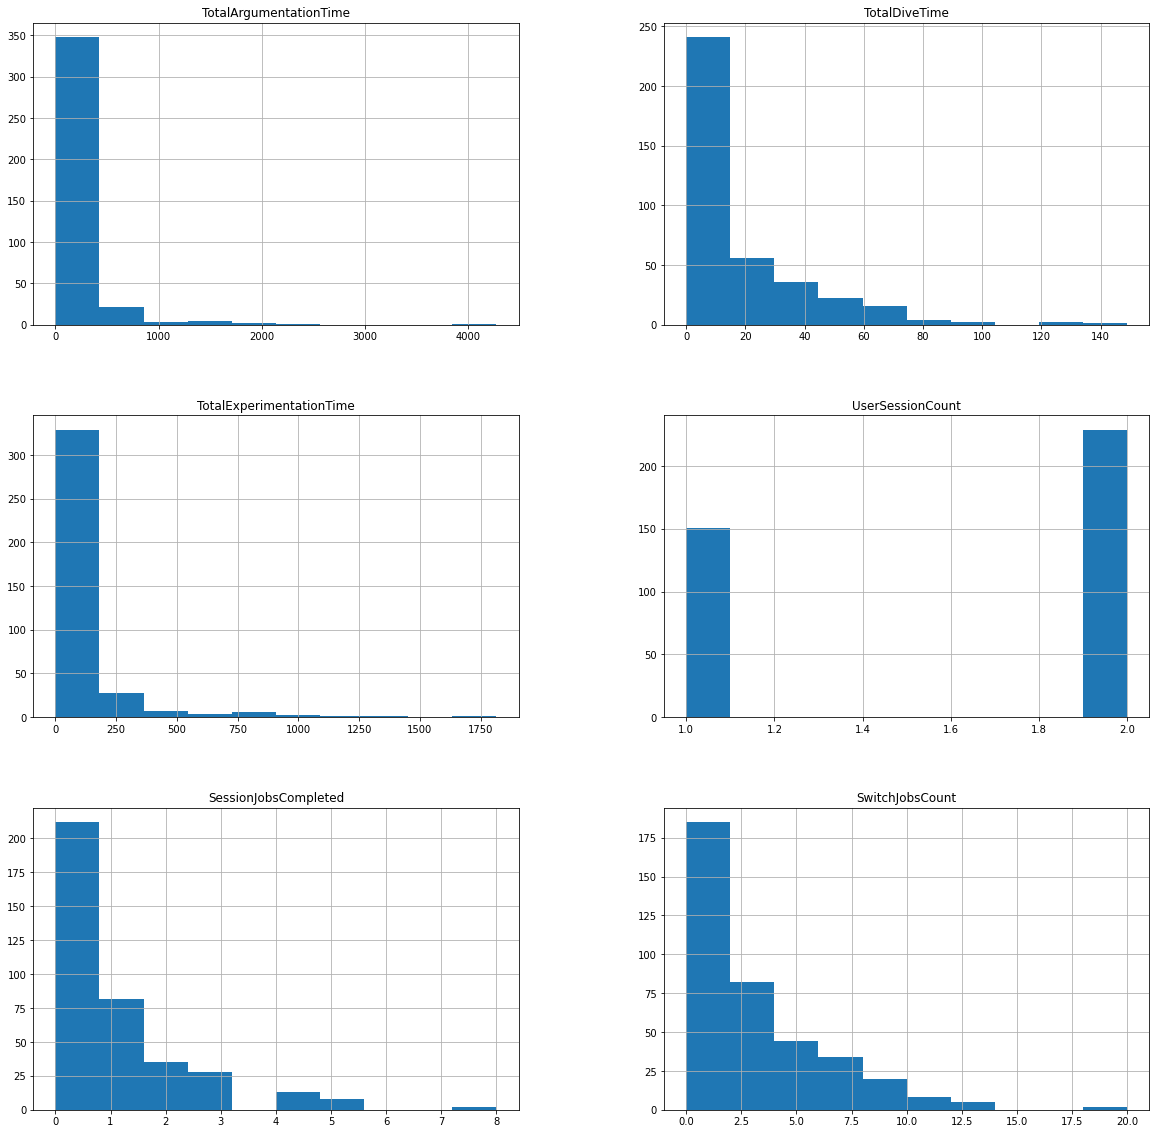

In [46]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

In [47]:
col1 = 'SessionJobsCompleted' #@param{type:"string"}
col2 = 'SwitchJobsCount'#@param{type:"string"}

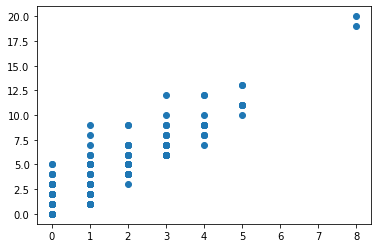

In [48]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])

In [49]:
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

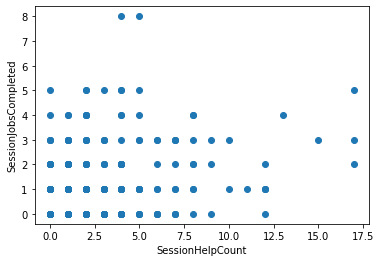

In [50]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
plt.xlabel(col1)
plt.ylabel(col2)

You may want to see more advanced relationship via plots. Here is an example

Text(0, 0.5, 'SessionJobsCompleted/ActiveTime')

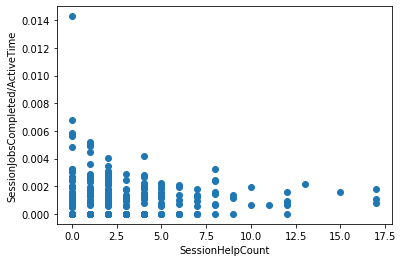

In [51]:
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.ActiveTime)
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/ActiveTime")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [52]:
#@markdown Choose your own metric for test here
Group_column = "TotalDiveTime" #@param {type:'string'}
Dividing_value = "20" #@param {type: 'string'}
Interested_column = "TotalExperimentationTime" #@param {type: 'string'}

In [53]:
df_Aggregate['groups'] = df_Aggregate[Group_column].ge(20)

In [54]:
df_Aggregate.shape

(380, 21)

In [55]:
pairwise = pairwise_tukeyhsd(endog=df_Aggregate[Interested_column], groups=df_Aggregate.groups, alpha=0.05)
print(pairwise)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 False   True   36.683 0.1157 -9.0625 82.4285  False
----------------------------------------------------


# Machine learning models with Scikit Learn

In [56]:
response = "SessionJobsCompleted"
predictors = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']

## preprocessing

In [57]:

x = df_Aggregate[predictors].values
y = df_Aggregate[response].values
std_x = StandardScaler().fit_transform(x)
std_y = StandardScaler().fit_transform(np.array(y)[:,np.newaxis])

## building model

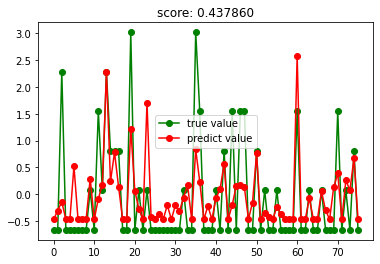

In [58]:
model = LR()
x_train, x_test, y_train, y_test = train_test_split(std_x, std_y, test_size=0.2, shuffle=True)
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
result = model.predict(x_test)
plt.figure()
plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
plt.title('score: %f'%score)
plt.legend()
plt.show()

## Cross validataion

In [59]:
scores = cross_validate(model, x_train, y_train, cv=5, return_train_score=False)

print(scores.keys())
pprint(scores)

dict_keys(['fit_time', 'score_time', 'test_score'])
{'fit_time': array([0.00137472, 0.00104094, 0.00102544, 0.00101924, 0.00102067]),
 'score_time': array([0.00090504, 0.00081301, 0.00087929, 0.00085115, 0.000633  ]),
 'test_score': array([0.44654316, 0.27871589, 0.3589748 , 0.15790215, 0.3927793 ])}


# Deep Neural network with Keras

## Classification tasks

### Spliting data

In [60]:
df_NN = df_Aggregate.copy()

In [61]:
Predictors = ['TotalArgumentationTime', 'TotalExperimentationTime',
              'SessionDiveSitesCount',
              'ActiveTime', 'SessionHelpCount']
Responses = ['SessionJobsCompleted', "TotalDiveTime"]
cut_value = [1, 20]

In [62]:
for r, v in zip(Responses, cut_value):
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [63]:
X = df_NN[Predictors]
y = df_NN[['group_' + r for r in Responses]]
X_norm = (X - X.min())/(X.max() - X.min())
X_norm = np.asarray(X_norm).astype('float32')
y_norm = (y - y.min())/(y.max() - y.min())
x_train_full, x_test, y_train_full, y_test = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, shuffle=True)
x_train.shape

(243, 5)

### Training models

In [64]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(y_train.shape[1], activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 300)               1800      
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 32,102
Trainable params: 32,102
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.003),
              metrics=[keras.metrics.binary_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [66]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=40)

Epoch 1/30
7/7 [==============================] - 1s 44ms/step - loss: 0.6925 - binary_accuracy: 0.7366 - val_loss: 0.6908 - val_binary_accuracy: 0.6885
Epoch 2/30
7/7 [==============================] - 0s 9ms/step - loss: 0.6912 - binary_accuracy: 0.7366 - val_loss: 0.6898 - val_binary_accuracy: 0.6885
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6899 - binary_accuracy: 0.7366 - val_loss: 0.6889 - val_binary_accuracy: 0.6885
Epoch 4/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6889 - binary_accuracy: 0.7366 - val_loss: 0.6879 - val_binary_accuracy: 0.6885
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6876 - binary_accuracy: 0.7366 - val_loss: 0.6868 - val_binary_accuracy: 0.6885
Epoch 6/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6864 - binary_accuracy: 0.7366 - val_loss: 0.6858 - val_binary_accuracy: 0.6885
Epoch 7/30
7/7 [==============================] - 0s 9ms/step - loss: 0.6852 - binary

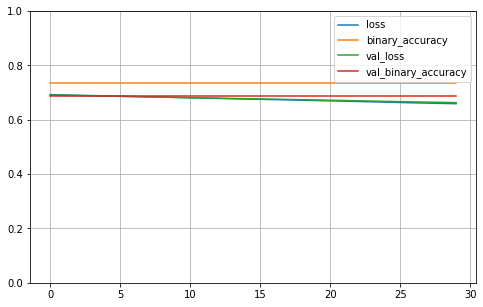

In [67]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# SOlution? REsolve

### Evaluation on the test data

In [68]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = model.predict(x_test[:3])
print("predictions:", predictions)
print("target_values:", y_test[:3])

Evaluate on test data
3/3 [==============================] - 0s 4ms/step - loss: 0.6508 - binary_accuracy: 0.7697
test loss, test acc: [0.6508499979972839, 0.7697368264198303]
Generate predictions for 2 samples
1/1 [==============================] - 0s 90ms/step
predictions: [[0.4546385  0.47081777]
 [0.45546988 0.467019  ]
 [0.45321342 0.46375987]]
target_values:      group_SessionJobsCompleted  group_TotalDiveTime
361                         0.0                  0.0
322                         0.0                  0.0
124                         1.0                  0.0


In [69]:
predictions = model.predict(x_test)

3/3 [==============================] - 0s 6ms/step


Take SessionJobsCompleted as an example

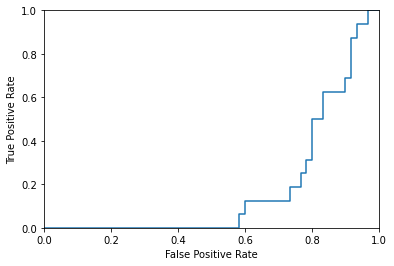

In [70]:
fpr , tpr , thresholds = roc_curve (y_true=y_test.iloc[:,0], y_score=predictions[:,0])
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show() 

In [71]:
print("auc score: ", roc_auc_score(y_test.iloc[:,0], predictions[:,0]))

auc score:  0.18229166666666669
